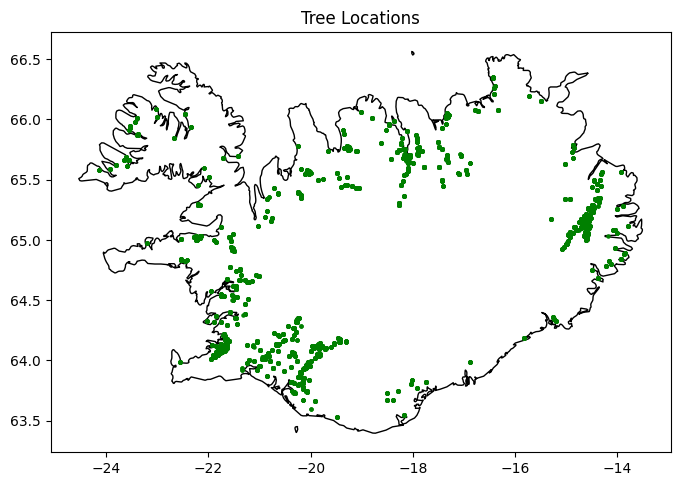

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load your tree data
gdf = gpd.read_file('output.gpkg')

# Load higher resolution country boundaries
# Downloaded here: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/
world_highres = gpd.read_file('countries/10m_cultural/ne_10m_admin_0_countries.shp')

# Filter Iceland
iceland = world_highres[world_highres['NAME'] == 'Iceland']

# Plot Iceland with high detail
ax = iceland.plot(color='white', edgecolor='black', figsize=(8, 8))

# Plot tree locations on top
gdf.plot(ax=ax, color='green', markersize=5)

# Show
plt.title('Tree Locations')
plt.show()


In [12]:
import numpy as np
import pandas as pd
import geopandas as gpd

# Function to load prediction and assign coordinates
def extract_predictions_with_coords(image_id):
    npy_path = f'Inference output/heights_{image_id}.npy'
    try:
        prediction_array = np.load(npy_path)
    except FileNotFoundError:
        print(f"Prediction file not found for {image_id}")
        return None

    image_rows = gdf[gdf['image'] == f'{image_id}.png'].copy()
    predictions = []

    for idx, row in image_rows.iterrows():
        x, y = int(round(row['px'])), int(round(row['py']))
        if 0 <= y < prediction_array.shape[0] and 0 <= x < prediction_array.shape[1]:
            predicted_value = prediction_array[y, x]
        else:
            predicted_value = np.nan
        predictions.append(predicted_value)

    image_rows['Predicted'] = predictions
    return image_rows.dropna(subset=['Predicted'])

# Process all images and collect predictions
results = []
for image_id in gdf['image'].str.replace('.png', '').unique():
    result = extract_predictions_with_coords(image_id)
    if result is not None:
        results.append(result)

# Combine all into a GeoDataFrame
if results:
    all_results = pd.concat(results, ignore_index=True)
    gdf_predictions = gpd.GeoDataFrame(all_results, geometry='geometry', crs='EPSG:4326')
else:
    print("No predictions found.")


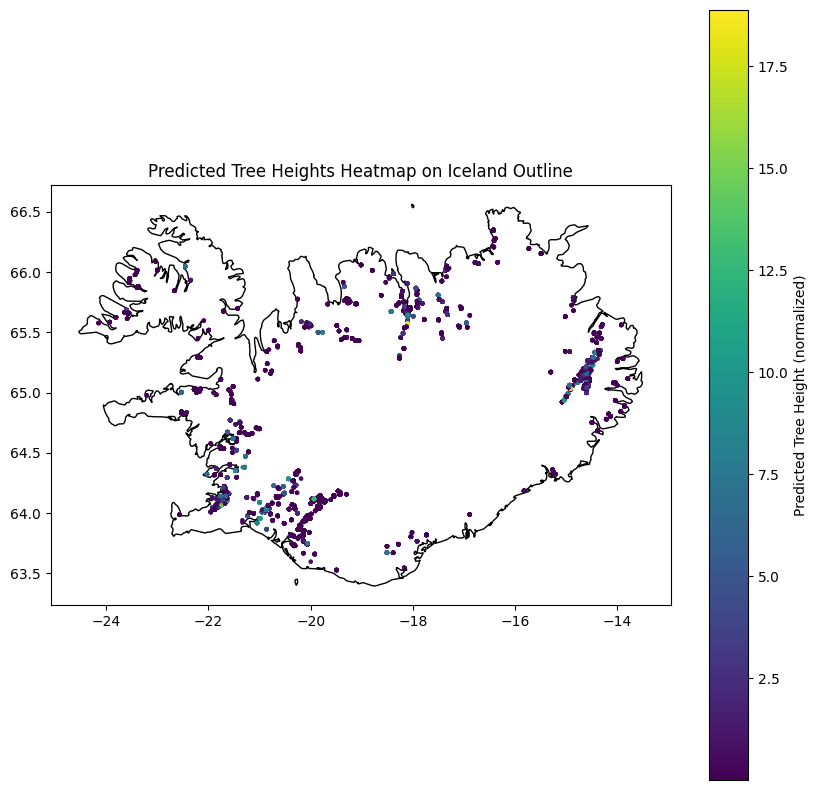

In [ ]:
import matplotlib.pyplot as plt

# Plot Iceland outline
ax = iceland.plot(color='white', edgecolor='black', figsize=(10, 10))

# Plot predicted heights as larger, higher-contrast points
gdf_predictions.plot(
    ax=ax,
    column='Predicted',
    cmap='YlOrRd',          # Changed colormap for better contrast (Yellow to Red)
    markersize=20,          # Increased marker size
    alpha=0.9,              # Less transparent points
    legend=True,
    legend_kwds={'label': "Predicted Tree Height (normalized)"}
)

# Finalize and show
plt.title('Predicted Tree Heights Heatmap on Iceland Outline')
plt.show()


In [14]:
# Count total number of predictions
total_predictions = len(gdf_predictions)

# Count per image (optional breakdown)
predictions_per_image = gdf_predictions['image'].value_counts()

# Display results
print(f"Total number of tree predictions: {total_predictions}")
print("\nNumber of predictions per image:")
print(predictions_per_image)


Total number of tree predictions: 11956

Number of predictions per image:
image
138711.png    62
123339.png    60
89321.png     52
41138.png     52
97986.png     51
              ..
41136.png      1
53507.png      1
35096.png      1
86862.png      1
38568.png      1
Name: count, Length: 550, dtype: int64
